In [179]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

matplotlib.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18

In [123]:
ds = pd.read_csv('data/wdds.csv')
ds.shape

(2097, 20)

In [41]:
ds = ds[~ds.type.isnull()]
ds.shape

(1559, 21)

let's look at the column that indicates the opinion type according to the taxonomy defined in the literature.

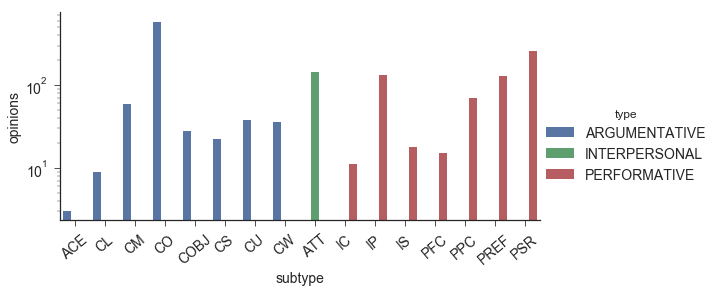

In [182]:
typedist=ds[['row_id','type','subtype']].groupby(['type', 'subtype']).count()
typedist.reset_index(inplace=True)
plt.figure(figsize=(15,3))
fg = seaborn.factorplot(x='subtype', y='row_id', hue='type', 
                        data=typedist, kind='bar', size=4, aspect=2)
fg.set_xticklabels(rotation=40)
plt.yscale('log')
plt.ylabel('opinions')
plt.savefig('output/annotatedopinionsdist.eps', format='eps')

In [132]:
labeldist=ds[['row_id','type']].groupby('type').size().reset_index()
labeldist.columns = ['type', 'N']
total = labeldist['N'].sum()
labeldist['perc'] = labeldist['N'] / total
labeldist

,type,N,perc
0,ARGUMENTATIVE,780,0.499680
1,INTERPERSONAL,145,0.092889
2,PERFORMATIVE,636,0.407431


Now, we are going to analyze if there are different labels in each turn (the whole edit made by an author, generally a paragraph)

In [68]:
lblfield='subtype'
lblturns = ds.groupby(['page_id', 'turn']).agg({lblfield:pd.Series.nunique})
lblturns = lblturns.reset_index()
turns = lblturns.groupby(lblfield).count().reset_index()
#turns[['type','page_id']].plot.barh()
total = turns.page_id.sum()
turns['perc'] = turns.page_id/float(total)
turns = turns[[lblfield, 'perc']]
turns.columns = ['Number of labels', 'Percentage']
turns.to_csv('output/labelsturnsdist.csv', index=False)
turns

,Number of labels,Percentage
0,1,0.533149
1,2,0.269337
2,3,0.116022
3,4,0.053867
4,5,0.022099
5,6,0.002762
6,7,0.001381
7,8,0.001381


In [53]:
ds.sample(2, random_state=3)

,row_id,page_id,page_title,contributor,timestamp,creation_dt,topic,opinion,clean_opinion,turn,...,type,subtype,type_r1,subtype_r1,type_r2,subtype_r2,stance,sentiment,url,agreement
1092,57,2238953,Barack Obama,190.16.192.200,1232768414,1/24/09 3:40,"sobre el uso de la palabra ""afroamericano""",pero wikipedia no busca la objetividad?,pero wikipedia no busca la objetividad?,28,...,ARGUMENTATIVE,CO,NaN,CO,NaN,CO,NaN,NaN,https://es.wikipedia.org/wiki/Discusión:Barack...,1.0
911,76,1204425,Evo Morales,Crichterm12,1218118505,8/7/08 14:15,la imparcialidad de wikipedia esta en riesgo,me parece que wikipedia debe cuidar de mantene...,me parece que wikipedia debe cuidar de mantene...,32,...,PERFORMATIVE,PSR,NaN,PSR,NaN,ATT+,NaN,NaN,https://es.wikipedia.org/wiki/Discusión:Evo_Mo...,0.0


## agreement

In [124]:
ds = ds[ds.subtype!='INVALID']
ds = ds[ds.subtype!='SIGN']
#ds=ds2[ds2.subtype=='CS'].copy()

In [126]:
from sklearn.metrics import cohen_kappa_score

labels = ds2.subtype.unique()
print(f'num labels:{ len(labels)}')

lblfield = 'subtype'
label_f1 = 'subtype_r1'
label_f2 = 'subtype_r2'
aggree_r1 = 'agreement_r1'
aggree_r2 = 'agreement_r2'
aggreement = 'po'
agreement_expected = 'pe'
rndlbl_r1 = 'rndlbl_r1'
rndlbl_r2 = 'rndlbl_r2'
# N
ds[aggree_r1] = ds[lblfield] == ds[label_f1]
ds[aggree_r2] = ds[lblfield] == ds[label_f2]
ds[aggreement] = ds[aggree_r1] & ds[aggree_r2]
# kappa
ds[rndlbl_r1] = ds2.subtype.sample(ds.shape[0], random_state=4).values
ds[rndlbl_r2] = ds2.subtype.sample(ds.shape[0], random_state=5).values
ds[agreement_expected] = ds[rndlbl_r1] == ds[rndlbl_r2] 

# ds[['subtype','subtype_r1','subtype_r2','agreement_r1', 
#     'agreement_r2', 'agreement', rndlbl_r1,rndlbl_r2, agreement_expected]]

ds[aggreement] = ds[aggreement].apply(lambda x: float(x))
ds[agreement_expected] = ds[agreement_expected].apply(lambda x: float(x))
ds_rs = ds.groupby(lblfield).agg({'row_id': 'count',
                                  aggreement: 'mean',
                                  agreement_expected:'mean'})
ds_rs = ds_rs.reset_index()
ds_rs.columns=['subtype','N', aggreement,agreement_expected]
#ds_rs['kappa'] = cohen_kappa_score(ds[label_f1], ds[label_f2], labels)
ds_rs['kappa'] = (ds_rs[aggreement] - ds_rs[agreement_expected])/(1-ds_rs[agreement_expected])
ds_rs.to_csv('output/agreement.csv', index=False)
ds_rs

num labels:18


,subtype,N,po,pe,kappa
0,ACE,3,0.000000,0.333333,-0.500000
1,ATT,145,0.006897,0.151724,-0.170732
2,CL,9,0.333333,0.111111,0.250000
3,CM,59,0.305085,0.169492,0.163265
4,CO,585,0.615385,0.170940,0.536082
5,COBJ,28,0.535714,0.107143,0.480000
6,CS,22,0.409091,0.227273,0.235294
7,CU,38,0.236842,0.184211,0.064516
8,CW,36,0.277778,0.138889,0.161290
9,IC,11,0.000000,0.000000,0.000000
